In [1]:
# show relatedness by degree in two ways
# 1) a table showing percentage of data which falls into 1st degree (0.5), 2nd degree (0.25), 
# 3rd degree (0.125), and below (< 0.125) relatedness
# 2) a histogram of the max relatedness by individual

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns

from IPython.display import display
import glob

In [3]:
#same params as used before
maf = '1e-2' # minor allele frequency: the frequency at which the second most common allele occurs in a given population
#variants present at a frequency below the stated cutoff are removed
hwe = '1e-10' # Hardy-Weinberg equilibrium exact test p-value. variants that deviate enough to generate this low
#of a pval are excluded
geno = '5e-2'# variants with missing call rates exceeding the provided value
prune_maf = '5e-2'# only minor alleles occurring at at least this frequency are considered
prune_r2 = '5e-1' # pairs of variants with squared correlation greater than the threshold are noted, 
#and variants are greedily pruned from the window until no such pairs remain
relcutoff = '5e-2'# excludes one member of each pair of samples with observed genomic relatedness greater than the 
#given cutoff value

In [4]:
# Dylan said this will let us edit in illustrator, we shall see!
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [5]:
resdir = 'gs://popgen-gwas/sraju_20210830_full_gwas/'


In [6]:
resdir

'gs://popgen-gwas/sraju_20210830_full_gwas/'

In [7]:
# phenotypes
phenotypes = ['MergeEpoch_SL_AgORSeqPos_Vs_PopControl',
             'MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl']
phenotypes

['MergeEpoch_SL_AgORSeqPos_Vs_PopControl',
 'MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl']

## Binned Freq Tables

In [8]:
# bin the max values and report a table
bins = [0, .075, 0.15, 0.35, 0.65]
mapping = {}
for i in range(1,len(bins)):
    mapping[i] = '%.3f - %.3f' % (bins[i-1], bins[i])
    
phenotype_vals = {}
max_rel_vals = {}

phenotype_summary = {}

for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_rel = os.path.join(pdir, 'rel')
    relbase = os.path.join(pdir_rel, 'prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    rel = pd.read_csv(relbase+'.rel.withids.tsv', sep='\t', index_col=0)
    for i in rel.index:
        rel.at[i,i] = np.nan # nan at the diagonal because this is the same individual
    
    max_rel_vals[p] = rel.max(axis=1)
    bin_indices = np.digitize(max_rel_vals[p], bins)
    bin_indices_ser = pd.Series(bin_indices, index=max_rel_vals[p].index).replace(mapping)
    phenotype_vals[p] = bin_indices_ser
    vc = bin_indices_ser.value_counts()
    summary = pd.concat([vc, vc / vc.sum()], axis=1).sort_index(axis=0).reset_index()
    summary.columns = ['degree', 'number', 'proportion']
    print(p)
    display(summary)
    summary.index = bins[1:]
    phenotype_summary[p] = summary

MergeEpoch_SL_AgORSeqPos_Vs_PopControl


,degree,number,proportion
0,0.000 - 0.075,466,0.505972
1,0.075 - 0.150,82,0.089034
2,0.150 - 0.350,122,0.132465
3,0.350 - 0.650,251,0.272530


MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl


,degree,number,proportion
0,0.000 - 0.075,852,0.519829
1,0.075 - 0.150,90,0.054912
2,0.150 - 0.350,81,0.049420
3,0.350 - 0.650,616,0.375839


## Histograms

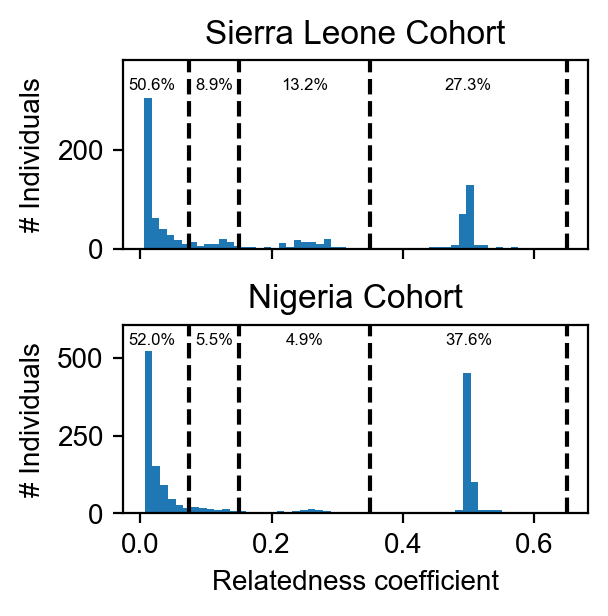

In [9]:
# hist of relatedness for max values
(fig,axes) = plt.subplots(2, 1, figsize=(3,3), dpi=200, sharex=True,
                         gridspec_kw={'hspace':.4})
titles = ['Sierra Leone Cohort', 'Nigeria Cohort']
midpoints = (np.diff(bins)/2) + bins[:-1]
midpoints[0] = .018
for i,p in enumerate(phenotypes):

    axes[i].set_ylabel('# Individuals')
    axes[i].hist(max_rel_vals[p], bins = 50) 
    axes[i].set_title(titles[i], fontsize=12)
    ylim = axes[i].get_ylim()
    ylim= (ylim[0], ylim[1] + 60)
    for b in bins[1:]:
        axes[i].vlines(x=b, ymin=0, ymax=ylim[1], linestyle='--')
    
    for j in range(phenotype_summary[p].shape[0]):
        s = '%.1f' % (phenotype_summary[p].iloc[j, 2]*100) + '%'
        axes[i].text(midpoints[j], ylim[1]-50,s,
                    ha='center', va='center', fontsize=6)
    
    
    axes[i].set_ylim(ylim)
    
axes[1].set_xlabel('Relatedness coefficient')
plt.savefig('../../figures/relatedness_histogram.pdf', bbox_inches='tight')
plt.savefig('../../figures/relatedness_histogram.png', bbox_inches='tight')

## Get breakdown by trio status

In [58]:
group_fn_pheno = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016_AggregatedLASVPhenotypes_20210829.tsv'
groups_pheno = pd.read_csv(group_fn_pheno, sep='\t')
groups_pheno.head(10)

,#IID,SEX,Batch,SampleType,CollectionEpoch,Disease,Epoch,Epoch_Bin,Country,Age,...,Pre2016_SL_LASV_AgORSeqPos,Pre2016_SL_LASV_PopControl,SL_LASV_Died,SL_LASV_DC,Post2016_SL_LASV_AgPos,Pre2016_SL_LASV_AgORSeqPos_Died,Pre2016_SL_LASV_AgORSeqPos_DC,Post2016_SL_LASV_AgPos_Died,Post2016_SL_LASV_AgPos_DC,Post2016_SL_EVD_CloseContact
0,WG0284565-DNA_A02_G-5231,2,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,38.0,...,False,False,False,False,False,False,False,False,False,False
1,WG0284565-DNA_A03_G-5686,2,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,10.0,...,False,False,False,False,False,False,False,False,False,False
2,WG0284565-DNA_A04_G-5690,1,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,16.0,...,False,False,False,False,False,False,False,False,False,False
3,WG0284565-DNA_A05_G-5135,2,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,49.0,...,False,False,False,False,False,False,False,False,False,False
4,WG0284565-DNA_A06_G-5045,2,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,24.0,...,False,False,False,False,False,False,False,False,False,False
5,WG0284565-DNA_A07_G-5510,1,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,40.0,...,False,False,False,False,False,False,False,False,False,False
6,WG0284565-DNA_A08_G-7030,1,1,SuspectedLassaSL,Post2016,Lassa,Post2016,1,1,41.0,...,False,False,True,False,True,False,False,True,False,False
7,WG0284565-DNA_A09_G-7022,2,1,SuspectedLassaSL,Post2016,Lassa,Post2016,1,1,13.0,...,False,False,True,False,True,False,False,True,False,False
8,WG0284565-DNA_A10_G-5687,2,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,19.0,...,False,False,False,False,False,False,False,False,False,False
9,WG0284565-DNA_A11_G-5135,2,1,SuspectedEbolaSL,Post2016,Ebola,Post2016,1,1,49.0,...,False,False,False,False,False,False,False,False,False,False


In [62]:
ngtrios = groups_pheno.loc[groups_pheno['SampleType']=='TriosNG','#IID']
sltrios = groups_pheno.loc[groups_pheno['SampleType']=='TriosSL','#IID']

In [65]:
p = 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl'
pd.crosstab(phenotype_vals[p], phenotype_vals[p].index.isin(sltrios))

col_0,False,True
row_0,,
0.000 - 0.075,423,43
0.075 - 0.125,37,11
0.125 - 0.350,135,21
0.350 - 0.650,131,120


In [66]:
p = 'MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl'
pd.crosstab(phenotype_vals[p], phenotype_vals[p].index.isin(ngtrios))

col_0,False,True
row_0,,
0.000 - 0.075,820,32
0.075 - 0.125,56,8
0.125 - 0.350,83,24
0.350 - 0.650,131,485
